RNN LSTM model with apollo dataset based on model explained in "SURROUND VEHICLE MOTION PREDICTION USING LSTM-RNN FOR MOTION PLANNING OF AVs"

Model changed

FC - LSTM - FC - FC(R) - FC(R) - FC(R) - FC

2 Stacked layer LSTM

Sequence output for 5
Good result

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn 
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [ ]:
path = '/content/drive/MyDrive/prediction_train'
names = ["frame_id",
        "object_id",
        "object_type",
        "pos_x",
        "pos_y",
        "pos_z",
        "object_length",
        "object_width",
        "object_height",
        "heading"]
i = 0

batch = {}

for filename in os.listdir(path):
  file = os.path.join(path, filename)
  df = pd.read_csv(file, sep=" ", header=None, names=names)

  for id in df.object_id.unique():
    batch_df = df[df["object_id"]==id]
    if len(batch_df)>50:
      batch[i] = batch_df
      i += 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
len(batch)

155

In [ ]:
# data preparation in LSTM format

def prep_data(data, timestep):
    # create timestep array of x and y
    pred_step = 5
    stack_count = len(data) - timestep - pred_step
    x = np.zeros(((stack_count,timestep,3)))
    y = np.zeros(((stack_count,pred_step,3)))
    #print(x.shape)

    for i in range(stack_count):
        x_temp = data[i:i+timestep]
        y_temp = data[i+timestep:i+timestep+pred_step]
        x_temp = x_temp[np.newaxis,:,:]
        y_temp = y_temp[np.newaxis,:,:]
        x[i] = x_temp
        y[i] = y_temp
    
    return x,y

Input layer (3) - FC layer (3) - LSTM layer (30) - LSTM layer (30) - FC layer (3) - Regression (3)

In [ ]:
# create a RNN LSTM model

class RNNLSTM(nn.Module):
    def __init__(self):
        super(RNNLSTM, self).__init__()
                
        self.num_classes = 3
        self.num_features = 3
        self.num_layers = 2
        self.hidden_size = 30
        
        self.fc1 = nn.Linear(self.num_features, 3)
        self.lstm1 = nn.LSTM(input_size = 3, hidden_size = self.hidden_size, 
                            num_layers = self.num_layers, batch_first=True) 
        
        self.fc2 = nn.Linear(30, 3)

        # regression
        self.fc3 = nn.Linear(3, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 3)
        self.relu = nn.ReLU()


    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        h_0 = h_0.to('cuda')
        c_0 = c_0.to('cuda')

        out = self.fc1(x)

        output, (hn,cn) = self.lstm1(x, (h_0,c_0))
        #print(output.shape)
        output1 = output[:,-5:,:]
        #print("without flip {} \n".format(output1))
        #output1 = torch.flip(output1, [0])
        #print("with flip {} \n".format(output1))

        # print(hn)

        hn = hn.view(-1, self.hidden_size)
        #print(hn.shape)

        out = self.fc2(output1)
        
        # regression layer
        out = self.fc3(out)
        out = self.relu(out)

        out = self.fc4(out)
        out = self.relu(out)

        out = self.fc5(out)
        out = self.relu(out)
        
        out = self.fc6(out)
        
        return out

rnn_lstm = RNNLSTM().to('cuda')
print(rnn_lstm)

RNNLSTM(
  (fc1): Linear(in_features=3, out_features=3, bias=True)
  (lstm1): LSTM(3, 30, num_layers=2, batch_first=True)
  (fc2): Linear(in_features=30, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=3, bias=True)
  (relu): ReLU()
)


In [ ]:
# training process

def train(x_train_tensor, y_train_tensor, rnn_lstm, loss_fn, optimizer, epochs):
    rnn_lstm.train()
    
    x_train_tensor = x_train_tensor.to('cuda')
    y_train_tensor = y_train_tensor.to('cuda')

    pred_output = rnn_lstm(x_train_tensor)
    # print(pred_output.shape)
    # print(y_train_tensor.shape)

    loss = loss_fn(pred_output, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #if epochs%100 == 0:
      #print("Epoch: {}, Loss: {} \n".format(epochs, loss.item()))
    return loss.item()

In [ ]:
# testing process

def test(x_test_tensor, y_test_tesnor, rnn_lstm, loss_fn):
    rnn_lstm.eval()
    test_loss = 0

    x_test_tensor = x_test_tensor.to('cuda')
    y_test_tesnor = y_test_tesnor.to('cuda')
    pred_output = rnn_lstm(x_test_tensor)
    test_loss = loss_fn(pred_output, y_test_tesnor).item()

    test_loss1 = test_loss/len(x_test_tensor)
    
    print("Avg loss: {} \n".format(test_loss1))
    print("Loss: {} \n".format(test_loss))
    return pred_output

In [ ]:
# dataset creation using data processing 
# and sending data to training 
epochs = 1000
lr = 0.0001
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_lstm.parameters(), lr=lr)

for epochs in range(epochs):

  i = 0
  loss_total = 0
  for i in range(150):
    # only for 1st 10 batches

    df = batch.get(i)
    data = df[["pos_x","pos_y","heading"]]

    #print(data.mean(axis = 0))

    data = StandardScaler().fit_transform(data)
    
    x_train,y_train = prep_data(data, 15)
    
    x_train_tensor = torch.from_numpy(x_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()

    loss = train(x_train_tensor, y_train_tensor, rnn_lstm, loss_fn, optimizer,epochs)
    loss_total += loss 

  print("Epoch: {}, Avg Loss: {} \n".format(epochs, loss_total/100))

Epoch: 0, Avg Loss: 0.09449311317875982 

Epoch: 1, Avg Loss: 0.08684542442671955 

Epoch: 2, Avg Loss: 0.08490977780893445 

Epoch: 3, Avg Loss: 0.08384898140095175 

Epoch: 4, Avg Loss: 0.08314767247065902 

Epoch: 5, Avg Loss: 0.08255125874653459 

Epoch: 6, Avg Loss: 0.0822411535307765 

Epoch: 7, Avg Loss: 0.08187905004248024 

Epoch: 8, Avg Loss: 0.08165254935622215 

Epoch: 9, Avg Loss: 0.08132486744783819 

Epoch: 10, Avg Loss: 0.08123767141252757 

Epoch: 11, Avg Loss: 0.08088097519241273 

Epoch: 12, Avg Loss: 0.08080493798479438 

Epoch: 13, Avg Loss: 0.08063697814941406 

Epoch: 14, Avg Loss: 0.08052354257553816 

Epoch: 15, Avg Loss: 0.08036916429176927 

Epoch: 16, Avg Loss: 0.08051945459097624 

Epoch: 17, Avg Loss: 0.0801686060987413 

Epoch: 18, Avg Loss: 0.08003755519166589 

Epoch: 19, Avg Loss: 0.07969279737211764 

Epoch: 20, Avg Loss: 0.07964043462648988 

Epoch: 21, Avg Loss: 0.07954526715911925 

Epoch: 22, Avg Loss: 0.07954313033260405 

Epoch: 23, Avg Loss: 0.

In [ ]:
# testing process

df_test = batch.get(10)

data_test = df_test[["pos_x","pos_y","heading"]]
#data_test = data_test.to_numpy()
data_test = StandardScaler().fit_transform(data_test)

print(np.mean(data_test, axis=0))

x_test,y_test = prep_data(data_test, 15)

x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
# print(x_train_tensor.shape)
# print(y_train_tensor.shape)

pred_output = test(x_test_tensor, y_test_tensor, rnn_lstm, loss_fn)

[-5.81909999e-16  1.53134210e-17  4.59402631e-17]
Avg loss: 0.0009925055660699542 

Loss: 0.037715211510658264 



In [ ]:
from sklearn.metrics import r2_score

pred_output_values1 = pred_output.data.cpu().numpy()
y_test_tesnor = y_test_tensor.numpy()

pred_output_values = savgol_filter(pred_output_values1, 15, 4, axis =0)

r2_posx = r2_score(y_test_tensor[:,:,0], pred_output_values[:,:,0])
r2_posy = r2_score(y_test_tensor[:,:,1], pred_output_values[:,:,1])
r2_heading = r2_score(y_test_tensor[:,:,2], pred_output_values[:,:,2])
print(r2_posx, r2_posy, r2_heading)

0.9628257104671798 0.9652107364580813 0.3930849527337655


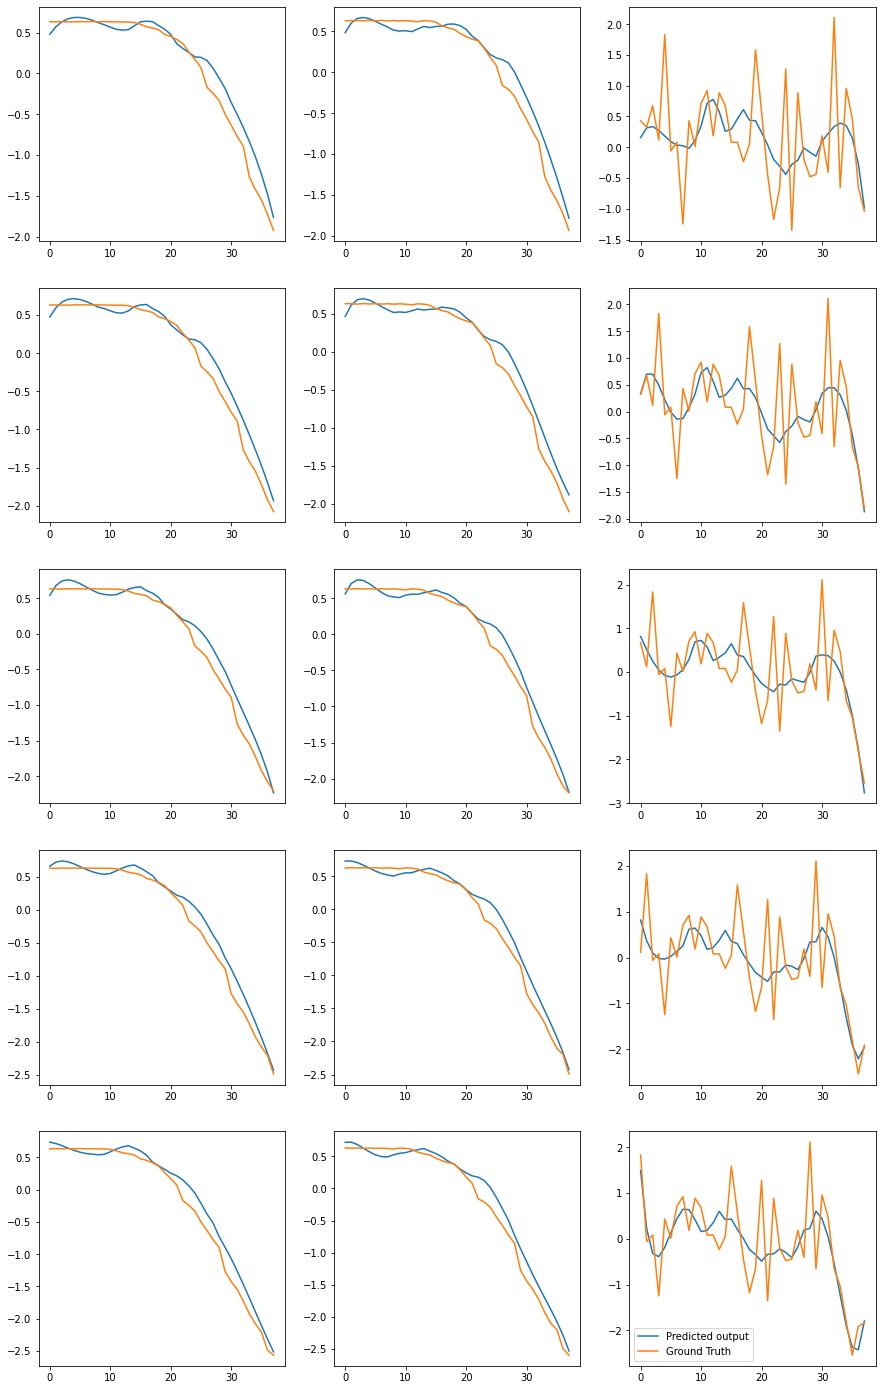

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.rcParams['figure.figsize'] = [15, 25]

for i in range(5):

  plt.subplot(5,3,(i*3)+1)
  plt.plot(pred_output_values[0:100, i, 0], label = "Predicted output")
  plt.plot(y_test_tensor[0:100, i, 0], label = "Ground Truth")

  plt.subplot(5,3,(i*3)+2)
  plt.plot(pred_output_values[0:100, i, 1], label = "Predicted output")
  plt.plot(y_test_tensor[0:100, i, 1], label = "Ground Truth")

  plt.subplot(5,3,(i*3)+3)
  plt.plot(pred_output_values[0:100, i, 2], label = "Predicted output")
  plt.plot(y_test_tensor[0:100, i, 2], label = "Ground Truth")



plt.legend()
plt.show()


In [ ]:
# save model

#torch.save(rnn_lstm.state_dict(), 'apollo_data_model1_seq15.pth')
#print('model save')


model save
